In [1]:
# %matplotlib notebook
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt, calendar
import os

# import seaborn as sns

### To do:
- Add some kind of snowmelt pulse indicator? Though already taken into account by discharge...
- Maybe add month as a feature in its own right?

Perhaps also:
- Add lake N species
- Add lake DIN:TP or TN:TP (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3996004/ for justification of which ratio to use)
- Better (more robust) lake TP flux estimate, e.g. monthly or seasonal fluxes. E.g. Beale or regression approach

Then also repeat the whole thing but just with seasonally-aggregated values, rather than monthly.

In [2]:
# User input
# Which Vansjø basin? Van1 (Storefjorden), Van2 (Vanemfjorden). To do: perhaps combine the two datasets?
basin = 'Van2'

# Include TP flux estimates in the data matrix?
inc_fluxes = 0 # 0 or 1

# FILE PATHS to input data

# Met (T, pptn)
met_fpath = r'../data/Daily_1km_gridded_data_Morsa.csv'
wind_fpath = r'../data/Obs_Rygge_MeanWindSpeed.csv' # Mean daily wind speed (m/s), Rygge airport
PET_fpath = r'../data/Morsa_ThornthwaitePET.csv' #N.B. calculated using met station temp rather than gridded. But the two are v. comparable (not so pptn)

# Discharge
Q_fpath = r'../data/3-22-0_D6pm_Hogfoss_Scaled_to_Kure.csv'

# Catchment water quality (at Kure)
catchwq_fpath = r'../data/003-59191_chem_obs.csv'

# Lake water quality
fname_dict = {'Van1':'Storefjorden (VAN1)', 'Van2':'Vanemfjorden (VAN2)'}
lakewq_fpath = r'../data/%s_chem_obs.csv'%fname_dict[basin]

# Alternative lake colour data (from Storefjorden, 20m depth, MOVAR data)
movar_color_fpath = r'../data/LakeColour_MOVAR.csv'

# Lake ecology (PTI, biovolume, cyanomax, cyano biovolume)
ecol_fpath = r'../data/%s_PTI_Cyano.xlsx'%basin

# Output files
out_file = r'../data/DataMatrices'

In [3]:
# READ IN
met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
pet_df = pd.read_csv(PET_fpath, index_col=0, parse_dates=True, dayfirst=True)
wind_df = pd.read_csv(wind_fpath, index_col=0, parse_dates=True, dayfirst=True)

Q_df = pd.read_csv(Q_fpath, index_col=0, parse_dates=True, dayfirst=True)

catchwq_df = pd.read_csv(catchwq_fpath, index_col=0, parse_dates=True, dayfirst=True)

lakewq_df = pd.read_csv(lakewq_fpath, index_col=0, parse_dates=True, dayfirst=True)
color_df = pd.read_csv(movar_color_fpath, index_col=0, parse_dates=True, dayfirst=True)

# If looking at Van2 (Vanemfjorden), also read in lake data from Storefjorden
if basin =='Van2':
    van1_fpath = r'../data/Storefjorden (VAN1)_chem_obs.csv'
    lakewq_df_van1 = pd.read_csv(van1_fpath, index_col=0, parse_dates=True, dayfirst=True)

# Read in ecol data from excel sheet one sheet at a time, then merge
PTI_df = pd.read_excel(ecol_fpath, sheet_name=0, index_col=3, parse_dates=True)
biovol_df = pd.read_excel(ecol_fpath, sheet_name=1, index_col=3, parse_dates=True)
cyanoBiovol_df = pd.read_excel(ecol_fpath, sheet_name=2, index_col=0, parse_dates=True)
ecol_df = pd.concat([PTI_df['PTI'], biovol_df['Biovolume_mm3_per_l'], cyanoBiovol_df['Cyano_biovol_mm3_per_l']], axis=1)

### Some quality control

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1b8855b70>,
      dtype=object)

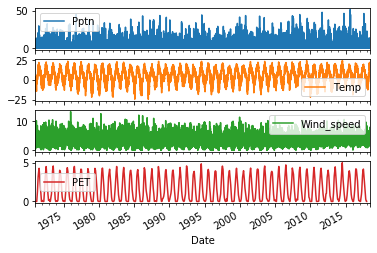

In [4]:
# For the met data, just pick the columns of interest and rename them
met_df = met_df[['RR','TG']]
met_df.columns = ['Pptn','Temp']
met_df.index.name = 'Date'

# Add mean daily wind speed (m/s)
met_df['Wind_speed'] = wind_df.iloc[:,0]

# Also add PET (mm/day)
met_df['PET'] = pet_df['PET']

met_df.plot(subplots=True)

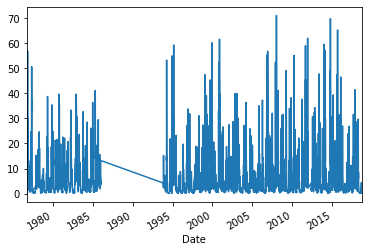

In [5]:
Q_df = Q_df['Q_18H_average_m3s_scaled']
Q_df.rename('Q', inplace=True)
Q_df.plot()

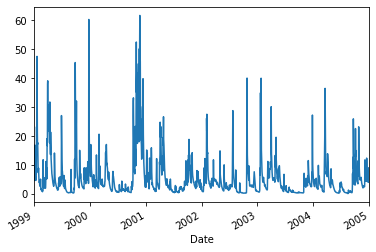

In [6]:
# Quick look at the autumn 2000 flood, thought to have caused the algal blooms in the period 2001-2007
Q_df.loc['1999-01-01':'2005-01-01'].plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1b3d0ee80>,
      dtype=object)

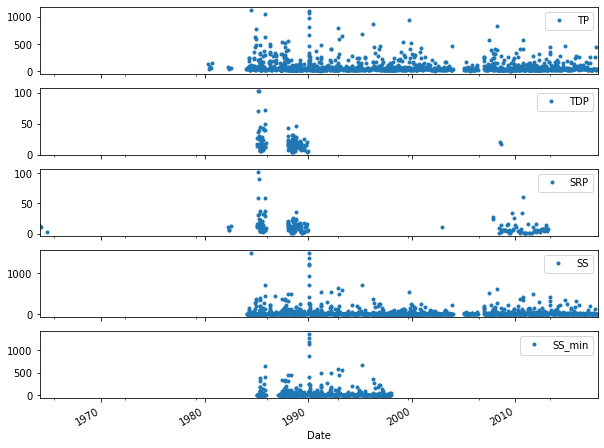

In [7]:
catchwq_df.plot(subplots=True, style='o', ms=3, figsize=(10,8))

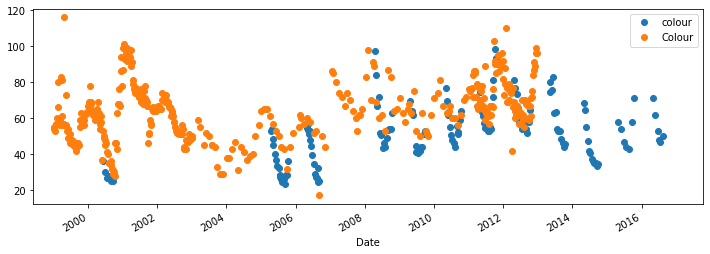

In [8]:
# Compare NIVA and MOVAR colour data (MOVAR data is shorter)

lakewq_df = pd.merge(lakewq_df, color_df, left_index=True, right_index=True, how='outer')

lakewq_df.loc['1998-01-01':,['colour','Colour']].plot(style='o', figsize=(12,4))

# Optionally output to csv for quick stats elsewhere
lakewq_df.loc['1998-01-01':,['colour','Colour']].dropna().to_csv(r'../data/lake_colour_comparison.csv')

Text(0.5, 0, 'MOVAR colour')

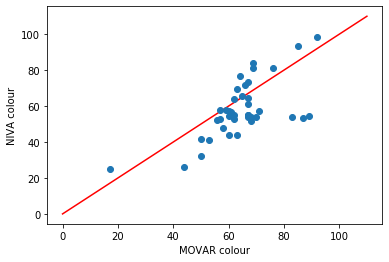

In [9]:
l = np.arange(0,120,10)
plt.plot(l,l,'r-')

plt.plot(lakewq_df['Colour'],lakewq_df['colour'], 'o')
plt.ylabel('NIVA colour')
plt.xlabel('MOVAR colour')

# plt.show()

**Colour**: MOVAR data covers much more of the period 2000-2012 than the NIVA data. However, stops in 2012. How to make a continuous time series for the period overlapping with the cyanobacteria observations (i.e. 1998-2018)? Want to use the MOVAR data and then the NIVA data, or a combination of the two. However, they are sampled from different lakes and depths (MOVAR data is from 20m deep in Storefjorden, NIVA data from the top 0-3m in Vanemfjorden). We can see they follow the same broad pattern between years and seasonally, but there are often offsets in the timing of rising and falling limbs (though this is most apparent in 2005-7, not so much in later years).

For now, **Just merge the two datasets**. But a mroe rigorous statistical comparison of the two datasets (or just getting hold of MOVAR data for the entire period) would be much preferable.

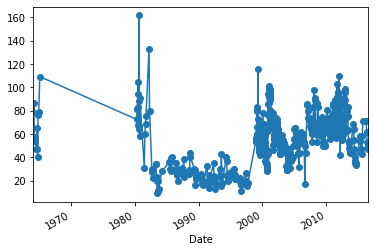

In [10]:
# Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
s0 = lakewq_df.loc[:'1998-12-31','colour']

id1 = lakewq_df['Colour'].first_valid_index()
s1 = lakewq_df['Colour'].loc[id1:]
s1.name = 'colour'

lastidx = lakewq_df.loc['2013-01-01':,'colour'].last_valid_index()
s2 = lakewq_df.loc['2013-01-01':lastidx,'colour']

colour = pd.concat([s0, s1,s2], axis=0).dropna()
colour.plot(style='o', linestyle='-')

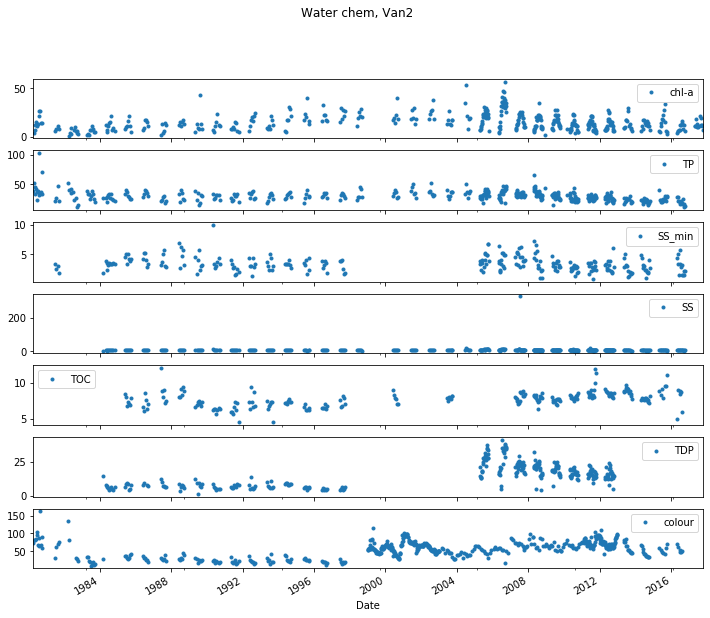

In [11]:
# Drop original MOVAR and NIVA colour series, and replace with the patched series
lakewq_df = lakewq_df.drop(['colour','Colour'], axis=1)
lakewq_df = lakewq_df.merge(colour.to_frame(), left_index=True, right_index=True, how='outer')

lakewq_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3, figsize=(12,10))
plt.suptitle('Water chem, %s' %basin)
# plt.savefig(r'../Figures/lake_chem_timeseries_%s.png' %basin)
plt.show()

**Seasonality:**
At Van2: TP over the summer generally roughly constant, sometimes increasing, sometimes increasing and then decreasing again.

At Van1: TP almost always starts high and then decreases over the summer

Perhaps because there's not as much stratification at the shallower Van2, so the top layer doesn't get depleted, and have more replenishment of TP from sediment-water interactions?

### Look at the ecology data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1b3973b00>,
      dtype=object)

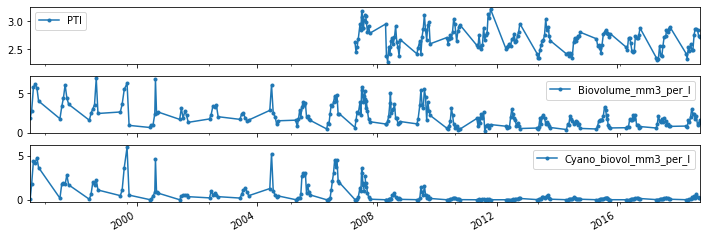

In [12]:
ecol_df.plot(subplots=True, style='o', ls='-', ms=3, figsize=(12,4))

**Comments:**

Van1 & Van2:
- Earliest lake data is in 1980, so drop all data from everything before then

- Dodgy data to be removed/not used:

    - Lake colour pre-August 1982
    - Lake dissolved P for Vansjø (TDP and SRP) show a big step-change between around 1998 and 2004. Not clear whether this is real, or either one side or the other of the step should be discarded. TP doesn't show this change. So for now only use TP and assume all dissolved P data (TDP, SRP) is dodgy
    - Mostly for plotting purposes, remove outliers from SS (and SS_min for Van1) (lake data): above 20 mg/l

- Precipitation data has one negative value; set to 0

Otherwise looks ok at first glance (aside from occasional outlier)

In [13]:
# Data cleaning based on plots above

lakewq_df.loc[:'1982-08-01','colour'] = np.NaN
lakewq_df[lakewq_df[['SS','SS_min']]>25.] = np.NaN
met_df.loc[met_df['Pptn']<0.,'Pptn'] = 0.

if basin == 'Van2':
    lakewq_df_van1.loc[:'1982-08-01','colour'] = np.NaN

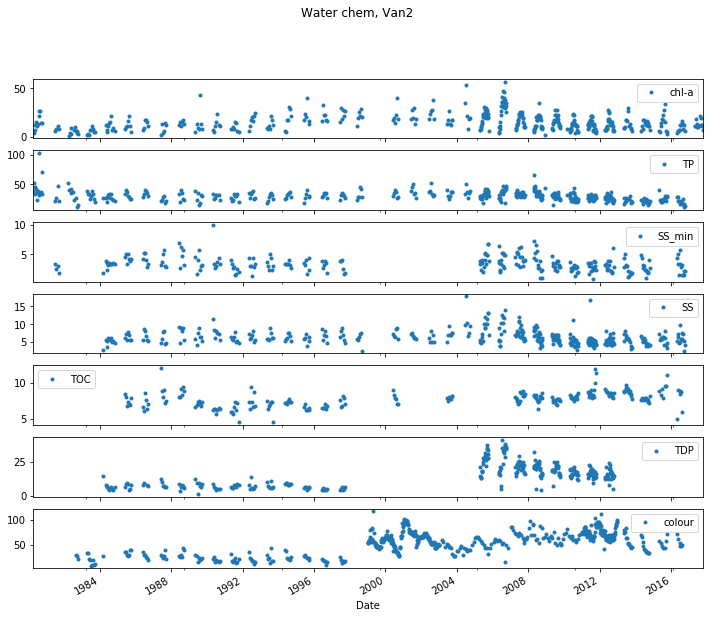

In [14]:
# Replot to see how it looks now

lakewq_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3, figsize=(12,10))
plt.suptitle('Water chem, %s' %basin)
# plt.savefig(r'../Figures/lake_chem_timeseries_%s.png' %basin)
plt.show()

### Useful functions and setup

### Combine data and add seasonal info

In [15]:
# Add suffixes to lake and water quality columns
catchwq_df = catchwq_df.add_suffix('_catch')
lakewq_df = lakewq_df.add_suffix('_lake')

if basin == 'Van2':
    lakewq_df_van1 = lakewq_df_van1.add_suffix('_van1')

In [16]:
# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME

if basin == 'Van2':
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df, lakewq_df_van1]
else:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=met_df.index)
    if i<1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc['1980-01-01':,:]

daily_df.columns.values

array(['Pptn', 'Temp', 'Wind_speed', 'PET', 'Q', 'TP_catch', 'TDP_catch',
       'SRP_catch', 'SS_catch', 'SS_min_catch', 'chl-a_lake', 'TP_lake',
       'SS_min_lake', 'SS_lake', 'TOC_lake', 'TDP_lake', 'colour_lake',
       'PTI', 'Biovolume_mm3_per_l', 'Cyano_biovol_mm3_per_l',
       'colour_van1', 'chl-a_van1', 'TP_van1', 'SS_min_van1', 'SS_van1',
       'TOC_van1', 'TDP_van1'], dtype=object)

In [17]:
# Drop some cols and rename others
   
if basin == 'Van2':
    cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
                    'TOC_lake','TDP_lake','SS_lake','SS_min_lake',
                    'TOC_van1', 'TDP_van1', 'SS_min_van1', 'SS_van1',]
else:
    cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
                    'TOC_lake','TDP_lake','SS_lake','SS_min_lake']
    
var_rename_dict = {'Biovolume_mm3_per_l':'Biovolume','Cyano_biovol_mm3_per_l':'CyanoBiovol'}

daily_df.drop(cols_to_drop, axis=1, inplace=True)
daily_df.rename(var_rename_dict, axis=1, inplace=True)

print(daily_df.columns.values)

['Pptn' 'Temp' 'Wind_speed' 'PET' 'Q' 'TP_catch' 'chl-a_lake' 'TP_lake'
 'colour_lake' 'PTI' 'Biovolume' 'CyanoBiovol' 'colour_van1' 'chl-a_van1'
 'TP_van1']


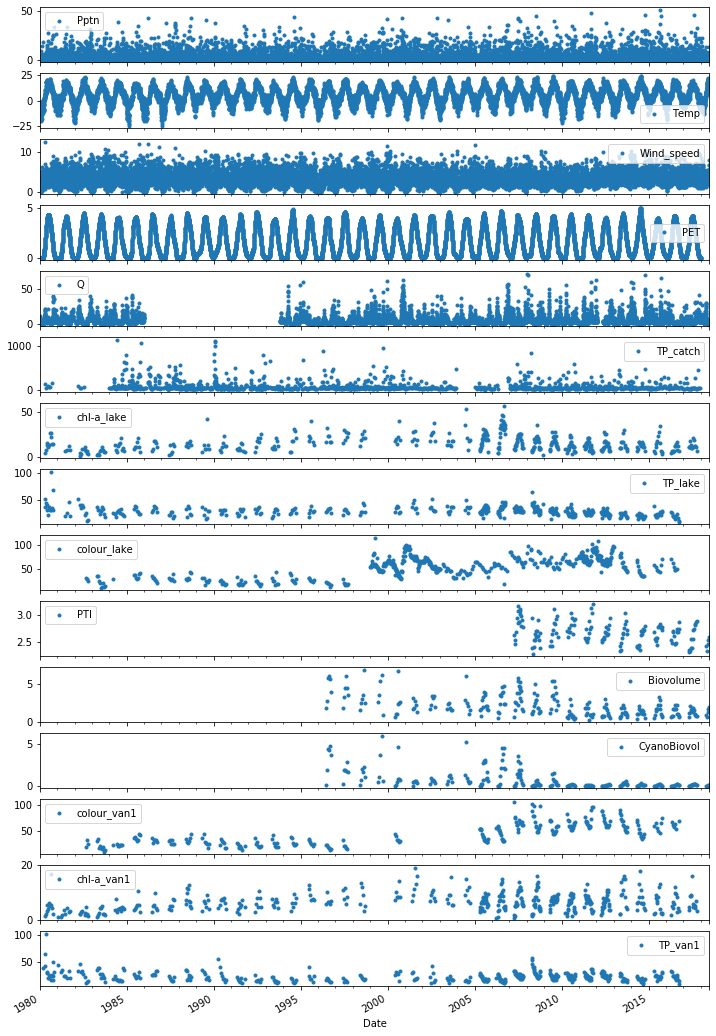

In [18]:
daily_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3, figsize=(12,20));

In [19]:
# How many data points do we have, and how many are missing?

def missing_data(df):
    # Number of missing in each column
    missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'N_missing'})

    # Number of data points & percent missing
    missing['N_data'] = df.notna().sum()
    missing['percent_missing'] = missing['N_missing'] / len(df)

    missing = missing.sort_values('percent_missing', ascending = False)
    return(missing)

missing_data(daily_df)

,N_missing,N_data,percent_missing
PTI,13907,153,0.989118
CyanoBiovol,13828,232,0.983499
Biovolume,13827,233,0.983428
colour_van1,13799,261,0.981437
TP_lake,13633,427,0.969630
chl-a_lake,13622,438,0.968848
TP_van1,13621,439,0.968777
chl-a_van1,13615,445,0.968350
colour_lake,13512,548,0.961024
TP_catch,12678,1382,0.901707


In [20]:
# Add derived variables from daily data

# Proxy for lake residence time (assume volume is constant, and so
# residence time is proportional to 1/outflow, and that outflow is
# proportional to discharge at Kure)
daily_df['rel_res_time'] = 1/daily_df['Q']

if inc_fluxes == 1:

    # Daily TP flux (rough estimate only!)
    # First, rough interpolation of TP concentration from Kure to daily
    TP_interp = daily_df['TP_catch'].resample('D').interpolate(method='linear',limit=31)

    fig = plt.figure(figsize=(9,6))

    ax0 = fig.add_subplot(3,1,1)
    daily_df['Q'].plot(ax=ax0)
    plt.ylabel('Q (m3/s)')

    ax1 = fig.add_subplot(3,1,2)
    TP_interp.plot(ax=ax1)
    plt.ylabel('Kure [TP] interp (ug/l)')
    daily_df['TP_catch'].plot(ax=ax1, style='r.')
    # Calc flux (kg/day)
    daily_df['TP_flux'] = daily_df['Q']*TP_interp*86400*(10**-6)

    ax2 = fig.add_subplot(3,1,3)
    daily_df['TP_flux'].plot(ax=ax2)
    plt.ylabel('Kure TP flux (kg/d)')
    
    daily_df['TP_flux'].describe()

In [21]:
# Precipitation features:
# (1) rain day (boolean of whether it rained that day or not)
def rain_day(pptn):
    if pptn>0.: return 1
    else: return 0
daily_df['Rain_day'] = daily_df['Pptn'].map(rain_day)
print (daily_df[['Pptn','Rain_day']].head())

                Pptn  Rain_day
Date                          
1980-01-01  0.000000         0
1980-01-02  0.000000         0
1980-01-03  0.000000         0
1980-01-04  2.693679         1
1980-01-05  3.016553         1


8.464601579400002
                Pptn  Pptn_intense
Date                              
1980-01-01  0.000000             0
1980-01-02  0.000000             0
1980-01-03  0.000000             0
1980-01-04  2.693679             0
1980-01-05  3.016553             0


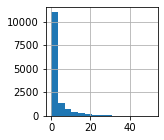

In [22]:
# (2) pptn intensity: Boolean saying whether precipitation is above a certain threshold
# First, take a look at the distribution of rainfall to decide on the threshold
daily_df['Pptn'].hist(bins=15, figsize=(2,2))
print (daily_df['Pptn'].quantile(q=0.90))

# Decide to use threshold of 90th percentile, 8.2 mm/day
def rain_intense(pptn):
    if pptn>8.2: return 1
    else: return 0
daily_df['Pptn_intense'] = daily_df['Pptn'].map(rain_intense)
print (daily_df[['Pptn','Pptn_intense']].head())

# Wind speed
Median daily wind speed is 3.3 m/s, and the distribution is somewhat right skewed. The main thing that is likely to be important for cyanobacteria is a stable upper water column, so that turbulence doesn't cause cells to sink. The duration of the stable upper water column could also be important, so features could be e.g. x days below whatever wind speed threshold is required for a stable upper water column, AND no (potentially short-lived) periods where the water column is mixed due to high winds.

Q0.1: 1.5 m/s
Q0.2: 2.0 m/s
Q0.3: 2.4 m/s
Q0.4: 2.9 m/s
Q0.5: 3.3 m/s


Q0.5: 3.3 m/s
Q0.6: 3.7 m/s
Q0.7: 4.2 m/s
Q0.8: 4.8 m/s
Q0.9: 5.8 m/s
            Wind_speed  Wind_under_Q0.2  Wind_over_Q0.5
Date                                                   
1980-01-01         2.9            False           False
1980-01-02         3.1            False           False
1980-01-03         1.5             True           False
1980-01-04         1.7             True           False
1980-01-05         1.5             True           False


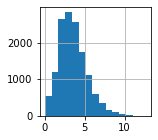

In [23]:
# Wind features: Boolean saying whether wind speed was above or below a certain threshold

# Distribution of wind speed
daily_df['Wind_speed'].hist(bins=15, figsize=(2,2))

# Define 'calm day' features
calm_quantiles = [0.1, 0.2, 0.3, 0.4, 0.5] 
for quantile in calm_quantiles:
    upper_threshold = daily_df['Wind_speed'].quantile(quantile)
    print('Q%s: %s m/s' %(quantile, upper_threshold))
    daily_df['Wind_under_Q%s' %quantile] = daily_df['Wind_speed'] < upper_threshold

print('\n')
    
# Define 'windy day' features
windy_quantiles = [0.5, 0.6, 0.7, 0.8, 0.9]
for quantile in windy_quantiles:
    lower_threshold = daily_df['Wind_speed'].quantile(quantile)
    print('Q%s: %s m/s' %(quantile, lower_threshold))
    daily_df['Wind_over_Q%s' %quantile] = daily_df['Wind_speed'] > lower_threshold
    
print (daily_df[['Wind_speed','Wind_under_Q0.2','Wind_over_Q0.5']].head())

## A bit of exploring of relationships between variables

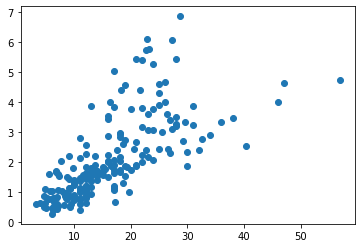

In [24]:
# Plot one variable against another

# plt.plot(np.log(daily_df['Q']), np.log(daily_df['TP_catch']),'o')
plt.plot(daily_df['chl-a_lake'], daily_df['Biovolume'],'o')

In [25]:
# pd.plotting.scatter_matrix(daily_df, figsize=(12,12))
# plt.show()

In [26]:
# Optionally output to csv
# daily_df.to_csv(os.path.join(out_file,'Vansjø_daily_data_%s.csv' %basin), index_label='Date')

## Resample

In [27]:
daily_df.columns

Index(['Pptn', 'Temp', 'Wind_speed', 'PET', 'Q', 'TP_catch', 'chl-a_lake',
       'TP_lake', 'colour_lake', 'PTI', 'Biovolume', 'CyanoBiovol',
       'colour_van1', 'chl-a_van1', 'TP_van1', 'rel_res_time', 'Rain_day',
       'Pptn_intense', 'Wind_under_Q0.1', 'Wind_under_Q0.2', 'Wind_under_Q0.3',
       'Wind_under_Q0.4', 'Wind_under_Q0.5', 'Wind_over_Q0.5',
       'Wind_over_Q0.6', 'Wind_over_Q0.7', 'Wind_over_Q0.8', 'Wind_over_Q0.9'],
      dtype='object')

In [28]:
# Set the aggregation method for different variables

vars_to_sum = ['Pptn','TP_flux','Rain_day','Pptn_intense', 'PET']

# Add wind cols
wind_cols = []
for q in calm_quantiles:
    wind_cols.append('Wind_under_Q%s' %q)
for q in windy_quantiles:
    wind_cols.append('Wind_over_Q%s' %q)
vars_to_sum += wind_cols

if inc_fluxes == 0:
    vars_to_sum.remove('TP_flux')
    
vars_to_average = ['TP_catch',
                 'CyanoBiovol',
                 'PTI',
                 'Temp',
                 'Q',
                 'Biovolume',
                 'rel_res_time',
                 'colour_lake',
                 'TP_lake',
                 'chl-a_lake',
                  'Wind_speed',
                  'SS_lake',
                  'TOC_lake',
                  'SS_catch']

if basin == 'Van2':
    vars_to_average.extend(['colour_van1','TP_van1','chl-a_van1'])

agg_method_dict = {} # Key: var, returns aggregation method
for var in daily_df.columns:
    if var in vars_to_sum:
        method = np.nansum
    elif var in vars_to_average:
        method = np.nanmean
    else:
        method = None
    agg_method_dict[var] = method

# agg_method_dict

### Resample to monthly

Poss response variables:
- TP_lake: mean lake TP concentration (ug/l)
- chl-a_lake: mean lake chl-a concentration (ug/l)
- CyanoBiovol: mean biovolume of cyanobacteria (mm3/l)
- Biovolume: mean total biovolume (mm3/l)
- 'Status_%s' %var. WFD class boundaries for vars TP_lake, chl-a_lake and CyanoBiovol, split into 3 classes: HG - high/good, M - moderate, PB - poor/bad
  
Other poss response variables that I haven't made matrices for yet:
- PTI: mean phytoplankton trophic index
- lake colour (if e.g. it turns out to be an important predictor for cyanobacteria)

Description of columns (this is all the possible explanatory variables; the exact selection will vary depending on the explanatory variable):

- colour_lake: mean lake colour (mg/l Pt (whatever pt means...?))
- Month: month of year, 1-12
- Pptn: monthly precipitation (mm/month)
- Pptn_intense: Number of days when rainfall was intense in the month (>90th percentile, 8.2mm/day)
- Q: Monthly mean of daily mean discharge at Kure (m3/s)
- Rain_day: Number of days of rain in the month
- Season: split into 4, wint: JFM, spr: AMJ, summ: JAS, aut: OND
- Season_2: boolean, split into 2: 0 for Nov-March (winter), 1 for Apr-Oct (summer)
- suffix _lag1M: value from the previous month
- suffix _lagxM_av, where x is between 2 and 3: Mean of values from previous x months (excluding current month)
- suffix _lagxM_sum, where x is between 2 and 6: Sum of values from previous x months (excluding current month)
- suffix '_prevSummer': mean of variable during the summer of the previous year (jun-aug), or WFD status calculated from mean of associated variables (starting with daily data)
- suffix '_winterSum': sum of values for previous winter (Oct-March incl.)
- Temp: Air temperature
- TP_catch: mean concentration of TP in the Hobølelva at Kure (ug/l)
- TP_flux: estimate of monthly TP flux in Hobølelva at Kure (kg/month). This inputs to Van1.
- TP_lake: mean lake TP concentration (ug/l)

If looking at van2 (Vanemfjorden), then inputs from the eastern basin (Storefjorden, van1), are also included as possible explanatory variables:
- TP_van1: Lake TP concentration at Van1 (ug/l). Associated lags too.
- chl-a_van1: Lake chl-a conc at Van1 (ug/l)
- colour_van1: Lake colour at Van1

In [29]:
import warnings
warnings.filterwarnings("ignore")

monthly_df = daily_df.resample('M').agg(agg_method_dict)

# This gives 0s for TP_flux sums where everything in the month was NaNs. Should be NaN.
# This is a bug, but for now correct for it re-setting as NaN
if inc_fluxes == 1:
    monthly_df.loc[monthly_df['TP_catch'].isnull(),'TP_flux'] = np.nan
    monthly_df.loc[monthly_df['Q'].isnull(),'TP_flux'] = np.nan

monthly_df.head()

,Pptn,Temp,Wind_speed,PET,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,PTI,...,Wind_under_Q0.1,Wind_under_Q0.2,Wind_under_Q0.3,Wind_under_Q0.4,Wind_under_Q0.5,Wind_over_Q0.5,Wind_over_Q0.6,Wind_over_Q0.7,Wind_over_Q0.8,Wind_over_Q0.9
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,22.434315,-8.091381,2.319355,0.000000,4.149765,NaN,NaN,NaN,NaN,NaN,...,9.0,14.0,17.0,17.0,24.0,7.0,6.0,3.0,2.0,0.0
1980-02-29,33.537067,-9.190934,2.403448,0.000000,0.345600,NaN,NaN,NaN,NaN,NaN,...,10.0,13.0,15.0,17.0,20.0,9.0,6.0,3.0,3.0,1.0
1980-03-31,36.902469,-4.001408,3.122581,4.107807,0.365793,NaN,NaN,NaN,NaN,NaN,...,3.0,8.0,9.0,10.0,18.0,13.0,9.0,6.0,3.0,0.0
1980-04-30,10.553205,4.218885,3.576667,34.443102,10.717172,130.0,3.971429,45.250000,NaN,NaN,...,3.0,5.0,6.0,10.0,16.0,14.0,12.0,8.0,3.0,2.0
1980-05-31,59.362142,11.237943,3.383871,89.630433,4.432067,50.0,9.948810,38.857143,NaN,NaN,...,0.0,2.0,6.0,11.0,15.0,15.0,11.0,5.0,3.0,1.0


In [30]:
# WFD class boundaries
# Units for TP and chl-a: ug/L. For cyanobacterial biovolume: mm3/L (=ug/l values /1000)
WFD_class_dict = {'TP_lake': {'G-M':20., 'M-P':39.},
                  'chl-a_lake': {'G-M':10.5, 'M-P':20.},
                  'CyanoBiovol': {'G-M':1., 'M-P':2.}
                 }

def classify_WFD(var,val):
    if np.isnan(val):
        return np.NaN
    elif val<WFD_class_dict[var]['G-M']:
        return 'HG'
    elif val<WFD_class_dict[var]['M-P']:
        return 'M'
    else:
        return 'PB'

for var in WFD_class_dict.keys():
    monthly_df['status_%s'%var] = monthly_df[var].apply(lambda x: classify_WFD(var, x))

In [31]:
# list(monthly_df.columns)

#### Add lagged variables  and month

In [32]:
# For all variables, add 1 month lag
for var in monthly_df.columns:
    monthly_df['%s_lag1M' %var] = monthly_df[var].shift(+1)

# Add a column for the month
monthly_df['Month'] = monthly_df.index.month
    
monthly_df[['chl-a_lake','TP_catch','TP_catch_lag1M']].head()

,chl-a_lake,TP_catch,TP_catch_lag1M
Date,,,
1980-01-31,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN
1980-04-30,3.971429,130.0,NaN
1980-05-31,9.948810,50.0,130.0


In [33]:
# For all variables that are summed on aggregating, calculate the sum for the
# previous winter (October - March)

# First, add a 'season_2' column, splitting data into 'winter' (Oct-March) and 'summer' (Apr-Sep)
# N.B. October lake sampling in 'winter' then
def growing_season(month):
    if month<4 or month>9:
        return 0
    else:
        return 1
monthly_df['season_2'] = monthly_df.index.month.map(growing_season)

# Then filter to just winter and calculate winter sums per year
wint_sum_df = monthly_df.loc[monthly_df['season_2']==0, vars_to_sum]

# Need to take account of fact that one season spans two years
wint_sum_df = wint_sum_df.iloc[3:] # Drop first 3 values, as only half a season
# Make series of years to sum over (e.g. Oct-Mar of yr-1 to yr)
yr_li = []
for yr in range(1981,2019):
    a = 6*[yr]
    yr_li.extend(a)
wint_sum_df['sum_yr'] = yr_li

if inc_fluxes == 1:
    # Do some patching: forward & backward fill up to one month of NaNs in TPflux
    wint_sum_df['TP_flux'].fillna(method='ffill',limit=1, inplace=True)
    wint_sum_df['TP_flux'].fillna(method='bfill',limit=1, inplace=True)

# Group by years and work out number of months with obs (for filtering
# out years where don't have enough months with obs). And sum!
wint_sum_df_counts = wint_sum_df.groupby('sum_yr').count()
wint_sum_df = wint_sum_df.groupby('sum_yr').sum()
if inc_fluxes == 1:
    # Filter out values with 1-3 months of observations
    wint_sum_df.loc[wint_sum_df_counts['TP_flux']<4,'TP_flux'] = np.NaN

# Add 1980, though it's NaN, for compatibility with monthly df
wint_sum_df.loc[1980] = len(wint_sum_df.columns)*[np.NaN]
wint_sum_df.sort_index(inplace=True)
# print (wint_sum_df.head())

for var in vars_to_sum:
    monthly_df['%s_winterSum' %var] = monthly_df[var].index.year.map(lambda x: wint_sum_df.loc[x,var])

# print monthly_df.loc['1981':'1982',['Rain_day','Rain_day_winterSum']]

In [34]:
# Next, means or sums of previous 2-3 months of except the lake vars.
# For the lake variables, the seasonal sampling (only April or May to Sep or Oct) means this
# lagging introduces too many missing values for the analysis

for var in vars_to_sum:
    for months in [2,3,4,5,6]:
        # First, shift one place so is lagged, then aggregate
        lagged_col = monthly_df[var].shift(+1)
        roll_sum = lagged_col.rolling(months, min_periods=months, closed='right').sum()
        monthly_df['%s_lag%sM_sum'%(var,months)] = roll_sum

# Replave vars_to_average with just non-lake vars, i.e.
for var in ['TP_catch','Temp','Q','rel_res_time']:
    for months in [2,3]:
        # First, shift one place so is lagged, then aggregate
        lagged_col = monthly_df[var].shift(+1)
        roll_mean = lagged_col.rolling(months, min_periods=months, closed='right').mean()
        monthly_df['%s_lag%sM_av'%(var,months)] = roll_mean

monthly_df[['Rain_day','Rain_day_lag2M_sum','Rain_day_lag3M_sum','TP_catch']].head()
# monthly_df[['TP_lake','TP_lake_lag2M_av','TP_lake_lag3M_av']].head(10)

,Rain_day,Rain_day_lag2M_sum,Rain_day_lag3M_sum,TP_catch
Date,,,,
1980-01-31,19,NaN,NaN,NaN
1980-02-29,17,NaN,NaN,NaN
1980-03-31,18,36.0,NaN,NaN
1980-04-30,10,35.0,54.0,130.0
1980-05-31,12,28.0,45.0,50.0


In [35]:
# Add mean for previous summer for in-lake ecol variables

prev_summ_vars = ['chl-a_lake', 'TP_lake', 'CyanoBiovol',
                 'status_chl-a_lake','status_TP_lake','status_CyanoBiovol']

if basin =='Van2':
    prev_summ_vars.extend(['chl-a_van1', 'TP_van1'])

# First, RESAMPLE TO SEASONAL

# Define 4 seasons per year. Lake sampling is from mid-April to mid-October.
# Value is returned for the last day of the season

def season(x):
    """Input month number, and return the season it corresponds to
    """
    if x in [12,1,2]:
        return 'wint'
    if x in [3,4,5]:
        return 'spr'
    if x in [6,7,8]:
        return 'summ'
    if x in [9,10,11]:
        return 'aut'

monthly_df['Season'] = monthly_df.index.month.map(season)

# Resample (enter 'Q' for quarterly, and '-month' for month to end in)
# N.B. if you change season function, need to change this too
season_df = daily_df.resample('Q-Feb').agg(agg_method_dict)
season_df['Season'] = season_df.index.month.map(season)

# Calculate WFD status for the season
for var in ['TP_lake','chl-a_lake', 'CyanoBiovol']:
    season_df['status_%s'%var] = season_df[var].apply(lambda x: classify_WFD(var, x))

# print (season_df.head(4))

# Map season from previous year to values in current year for summer months
summer_df = season_df.loc[season_df['Season']=='summ',prev_summ_vars]
summer_df['Year+1'] = summer_df.index.year + 1
# print (summer_df.head())

for var in prev_summ_vars:
    for idx in monthly_df.index:
        # First year with data is 1980, so no values for previous year. In this case, add NaNs
        if idx.year < 1981:
            prev_summer_val = np.nan
        else:
            prev_summer_val = summer_df[var].loc[summer_df['Year+1']==idx.year].values

        
        monthly_df.loc[idx, '%s_prevSummer'%var] = prev_summer_val
        
        
monthly_df[['TP_lake','TP_lake_prevSummer','status_TP_lake','status_TP_lake_prevSummer']].head(13)

,TP_lake,TP_lake_prevSummer,status_TP_lake,status_TP_lake_prevSummer
Date,,,,
1980-01-31,NaN,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN,NaN
1980-04-30,45.250000,NaN,PB,NaN
1980-05-31,38.857143,NaN,M,NaN
1980-06-30,32.633333,NaN,M,NaN
1980-07-31,36.761905,NaN,M,NaN
1980-08-31,67.400000,NaN,PB,NaN
1980-09-30,33.857143,NaN,M,NaN


In [99]:
# print (len(monthly_df.columns))
# sorted(monthly_df.columns)

## Split into separate matrices for the 4 possible response variables

### 1) Response var = lake TP concentration

In [100]:
sorted(monthly_df.columns)

['Biovolume',
 'Biovolume_lag1M',
 'CyanoBiovol',
 'CyanoBiovol_lag1M',
 'CyanoBiovol_prevSummer',
 'Month',
 'PET',
 'PET_lag1M',
 'PET_lag2M_sum',
 'PET_lag3M_sum',
 'PET_lag4M_sum',
 'PET_lag5M_sum',
 'PET_lag6M_sum',
 'PET_winterSum',
 'PTI',
 'PTI_lag1M',
 'Pptn',
 'Pptn_intense',
 'Pptn_intense_lag1M',
 'Pptn_intense_lag2M_sum',
 'Pptn_intense_lag3M_sum',
 'Pptn_intense_lag4M_sum',
 'Pptn_intense_lag5M_sum',
 'Pptn_intense_lag6M_sum',
 'Pptn_intense_winterSum',
 'Pptn_lag1M',
 'Pptn_lag2M_sum',
 'Pptn_lag3M_sum',
 'Pptn_lag4M_sum',
 'Pptn_lag5M_sum',
 'Pptn_lag6M_sum',
 'Pptn_winterSum',
 'Q',
 'Q_lag1M',
 'Q_lag2M_av',
 'Q_lag3M_av',
 'Rain_day',
 'Rain_day_lag1M',
 'Rain_day_lag2M_sum',
 'Rain_day_lag3M_sum',
 'Rain_day_lag4M_sum',
 'Rain_day_lag5M_sum',
 'Rain_day_lag6M_sum',
 'Rain_day_winterSum',
 'Season',
 'TP_catch',
 'TP_catch_lag1M',
 'TP_catch_lag2M_av',
 'TP_catch_lag3M_av',
 'TP_lake',
 'TP_lake_lag1M',
 'TP_lake_prevSummer',
 'TP_van1',
 'TP_van1_lag1M',
 'TP_van1_p

In [101]:
# First, lake TP concentration is the explanatory variable.
# So drop all ecological-related stuff. Biol could use up P, and therefore have
# a negative relationship with TP. But correlations are all positive (i.e.
# relationship seems to be mostly the other way around), so remove for
# simplicity. Also drop relative residence time, as it's a function of Q, and
# not looking particularly important compared to Q

cols_to_drop = [
 'Biovolume',
 'Biovolume_lag1M',
#  'Biovolume_lag2M_av',
#  'Biovolume_lag3M_av',
 'chl-a_lake',
 'chl-a_lake_lag1M',
#  'chl-a_lake_lag2M_av',
#  'chl-a_lake_lag3M_av',
 'chl-a_lake_prevSummer',
 'colour_lake',
 'colour_lake_lag1M',
#  'colour_lake_lag2M_av',
#  'colour_lake_lag3M_av', 
 'CyanoBiovol',
 'CyanoBiovol_lag1M',
#  'CyanoBiovol_lag2M_av',
#  'CyanoBiovol_lag3M_av',
 'CyanoBiovol_prevSummer',
 'PTI',
 'PTI_lag1M',
#  'PTI_lag2M_av',
#  'PTI_lag3M_av',
 'status_CyanoBiovol',
 'status_CyanoBiovol_lag1M',
 'status_CyanoBiovol_prevSummer',
 'status_chl-a_lake',
 'status_chl-a_lake_lag1M',
 'status_chl-a_lake_prevSummer',
 'status_TP_lake',
 'status_TP_lake_lag1M',
 'status_TP_lake_prevSummer']
#  'rel_res_time',
#  'rel_res_time_lag1M',
#  'rel_res_time_lag2M_av',
#  'rel_res_time_lag3M_av',

if basin == 'Van2':
    extra_cols_to_drop = [
    'chl-a_van1',
    'chl-a_van1_lag1M',
#     'chl-a_van1_lag2M_av',
#     'chl-a_van1_lag3M_av',
    'chl-a_van1_prevSummer',
    'colour_van1',
    'colour_van1_lag1M',
#     'colour_van1_lag2M_av',
#     'colour_van1_lag3M_av'
    ]
    cols_to_drop = cols_to_drop+extra_cols_to_drop

monthly_df_lakeTP = monthly_df.drop(cols_to_drop,axis=1)
print (len(monthly_df_lakeTP))

# Drop any rows where TP_lake is a NaN
monthly_df_lakeTP.dropna(subset=['TP_lake'], inplace=True)
print (len(monthly_df_lakeTP))
monthly_df_lakeTP.head()

462
198


,Pptn,Temp,Wind_speed,PET,Q,TP_catch,TP_lake,TP_van1,rel_res_time,Rain_day,...,TP_catch_lag3M_av,Temp_lag2M_av,Temp_lag3M_av,Q_lag2M_av,Q_lag3M_av,rel_res_time_lag2M_av,rel_res_time_lag3M_av,Season,TP_lake_prevSummer,TP_van1_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-04-30,10.553205,4.218885,3.576667,34.443102,10.717172,130.0,45.250000,53.559028,0.168976,10,...,NaN,-6.596171,-7.094574,0.355697,1.620386,2.973641,2.097454,spr,NaN,NaN
1980-05-31,59.362142,11.237943,3.383871,89.630433,4.432067,50.0,38.857143,67.075000,0.287349,12,...,NaN,0.108739,-2.991152,5.541483,3.809522,1.553389,2.038752,spr,NaN,NaN
1980-06-30,131.738069,15.539921,3.016667,122.847223,4.893233,80.0,32.633333,24.444444,0.264810,25,...,NaN,7.728414,3.818473,7.574620,5.171677,0.228162,1.131376,summ,NaN,NaN
1980-07-31,51.099007,16.605522,2.900000,129.314046,3.487091,75.0,36.761905,22.888889,0.435075,26,...,86.666667,13.388932,10.332250,4.662650,6.680824,0.276079,0.240378,summ,NaN,NaN
1980-08-31,96.991814,14.394161,3.141935,101.334177,1.856323,70.0,67.400000,20.345238,0.785827,24,...,68.333333,16.072722,14.461129,4.190162,4.270797,0.349942,0.329078,summ,NaN,NaN


In [102]:
missing_data(monthly_df_lakeTP).head(15)

,N_missing,N_data,percent_missing
Q_lag3M_av,47,151,0.237374
rel_res_time_lag3M_av,47,151,0.237374
Q_lag2M_av,44,154,0.222222
rel_res_time_lag2M_av,44,154,0.222222
Q_lag1M,41,157,0.207071
rel_res_time_lag1M,41,157,0.207071
Q,40,158,0.202020
rel_res_time,40,158,0.202020
TP_van1_lag1M,39,159,0.196970
TP_lake_lag1M,39,159,0.196970


In [103]:
# Take a look at what's missing
# First, drop any columns which don't have NaNs, then plot
# monthly_df_lakeTP.loc[:, monthly_df_lakeTP.isna().any()].plot(subplots=True, figsize=(12,30))

In [104]:
X = monthly_df_lakeTP.drop(['TP_lake'],axis=1)
y = monthly_df_lakeTP['TP_lake']
corr_df = X.corrwith(y)
corr_df.sort_values()

Wind_over_Q0.9_winterSum    -0.219525
Wind_over_Q0.5_winterSum    -0.212072
Wind_over_Q0.6_winterSum    -0.210361
Wind_over_Q0.5_lag6M_sum    -0.200332
Wind_over_Q0.7_winterSum    -0.189707
Wind_over_Q0.8_lag6M_sum    -0.181722
Wind_over_Q0.8_winterSum    -0.168603
Wind_over_Q0.5_lag5M_sum    -0.163672
Wind_over_Q0.7_lag6M_sum    -0.162814
Pptn_intense_lag1M          -0.159657
Wind_over_Q0.6_lag6M_sum    -0.156682
Wind_over_Q0.9_lag6M_sum    -0.155214
Wind_over_Q0.8_lag5M_sum    -0.144778
Wind_over_Q0.8_lag1M        -0.140184
Wind_over_Q0.6              -0.137668
Wind_over_Q0.8_lag2M_sum    -0.131736
Wind_over_Q0.5_lag4M_sum    -0.126503
Month                       -0.121309
Wind_over_Q0.7_lag5M_sum    -0.121258
Wind_over_Q0.6_lag5M_sum    -0.120127
Pptn_intense_lag2M_sum      -0.118566
Wind_over_Q0.9_lag5M_sum    -0.112199
Pptn_intense_lag3M_sum      -0.108549
Wind_speed                  -0.106528
Wind_over_Q0.7              -0.104577
Wind_over_Q0.8_lag4M_sum    -0.100517
Wind_over_Q0

In [105]:
monthly_df_lakeTP.to_csv(os.path.join(out_file,'dataMatrix_monthly_TP_%s.csv'%basin), index_label='Date')

**Comments:**

Van 2 (Vanemfjorden):
- Strongest correlation is with lake SS conc (0.49), unsurprising as lots of TP is particulate P, and also because the same processes control them (catch input and resuspension). Not an explanatory variable though, so drop.
- by far the best potential explanatory variables are lake TP concentration from the previous 1-3 months, then the previous summer (correlation coefficients 0.3 to 0.5).
- TP concentration in Storefjorden (Van1) potentially exerts some influence (0.3), or just controlled by similar factors
- Wind effect is also quite apparent: the calmer the previous winter/2-6 months (number of days when wind speed under Q0.2-0.3), the higher the TP (CCs 0.26 and lower)
  conversely, the windier the previous winter/6 months (number of days when wind speed >Q0.9 or 0.5), the lower the TP (CCs about -0.2). What is going on here? Less wind -> more TP, i.e. it's not resuspension (that would be more wind -> more TP). So must instead be related to mixing of the water column? i.e. less wind, have more TP accumulation at the surface? The time lag is interesting though, it seems to be the winter wind effect that is most important, or at least the previous 6 months, rather than the previous month. Suggests a longer-term effect. Could be related to ice cover then? Calmer -> earlier ice development and more stable -> ...?
- Everything else much weaker (ccs less than 0.16).
- **No link to air T seen, unlike Storefjorden**. Because it's shallower?
- No relation with met variables relating to delivery. Suggesting internal processing and P sources are more important?

Van 1 (Storefjorden): (N.B. not re-run with wind vars included)
- Strong negative correlation with air temperature the previous month (up to -0.6) & lags, month
- Strong positive correlation with lake TP previous month (0.6), and lags
- Weaker but still pretty ok +ve correlations (around 0.35-0.45): Q & Q-1M, rain days over past 5-6 months, TP fluxes (4-6M), Pptn sum (6M)
- (though small -ve correlations with e.g. rain days, intense pptn days and pptn in the current month...)
- Lake colour positively correlated to lake TP (cc ~0.5)

i.e. Storefjorden shows much stronger relationship to temp and precipitation. Why such a strong negative relationship with air temperature?! Warmer = lower lake TP. Due to biol using it up? But correlation with chl-a is weaker (-0.3), biovol weaker still (-0.2). Most likely due to **stratification**? Warmer=stable, stratified waters that are depleted in P, versus mixing and more P-rich waters in winter??

Unlike Vanemfjorden, Storefjorden TP conc also potentially influenced by catchment inputs over last few months. Suggests perhaps that delivery is more important than internal processing here, whilst internal fluxes swamp delivery signal in Vanemfjorden? 

### 2) Response var = Lake chl-a concentration

In [106]:
# 2) chl-a concentration
# cols to drop:
cols_to_drop = ['Biovolume',
 'Biovolume_lag1M',
#  'Biovolume_lag2M_av',
#  'Biovolume_lag3M_av',
 'CyanoBiovol',
 'CyanoBiovol_lag1M',
#  'CyanoBiovol_lag2M_av',
#  'CyanoBiovol_lag3M_av',
 'CyanoBiovol_prevSummer',
 'PTI',
 'PTI_lag1M',
#  'PTI_lag2M_av',
#  'PTI_lag3M_av',
 'rel_res_time',
 'rel_res_time_lag1M',
 'rel_res_time_lag2M_av',
 'rel_res_time_lag3M_av',
 'status_CyanoBiovol',
 'status_CyanoBiovol_lag1M',
 'status_CyanoBiovol_prevSummer',
 'status_TP_lake',
 'status_TP_lake_lag1M',
 'status_TP_lake_prevSummer',
 'status_chl-a_lake',
 'status_chl-a_lake_lag1M',
 'status_chl-a_lake_prevSummer'
               ]

monthly_df_lake_chla = monthly_df.drop(cols_to_drop,axis=1)
print (len(monthly_df_lake_chla))

# Drop any rows where explanatory variable value is a NaN
monthly_df_lake_chla.dropna(subset=['chl-a_lake'], inplace=True)
print (len(monthly_df_lake_chla))
# monthly_df_lake_chla.head()

462
202


In [107]:
X = monthly_df_lake_chla.drop(['chl-a_lake'],axis=1)
y = monthly_df_lake_chla['chl-a_lake']
corr_df = X.corrwith(y)
corr_df.sort_values()

Q_lag1M                     -0.386850
TP_van1                     -0.357043
Q                           -0.356612
Wind_under_Q0.1_lag3M_sum   -0.325854
Wind_under_Q0.1_lag2M_sum   -0.314300
Wind_under_Q0.2_lag3M_sum   -0.303631
Q_lag2M_av                  -0.298473
Wind_over_Q0.9              -0.298409
Wind_under_Q0.1_lag4M_sum   -0.286841
Wind_under_Q0.2_lag2M_sum   -0.277157
Wind_over_Q0.8              -0.274945
Wind_under_Q0.2_lag4M_sum   -0.269578
Wind_over_Q0.9_lag5M_sum    -0.260097
Wind_over_Q0.9_lag4M_sum    -0.259826
Wind_over_Q0.9_lag1M        -0.244462
Wind_speed                  -0.243500
Wind_under_Q0.3_lag3M_sum   -0.240656
Wind_over_Q0.9_lag2M_sum    -0.240392
TP_van1_lag1M               -0.239931
Wind_over_Q0.7_winterSum    -0.239643
Wind_over_Q0.9_lag3M_sum    -0.238593
Wind_over_Q0.9_lag6M_sum    -0.233229
Wind_under_Q0.3_lag2M_sum   -0.231686
colour_van1                 -0.227215
Wind_over_Q0.7              -0.218510
Wind_over_Q0.8_lag1M        -0.215040
Wind_under_Q

**Comments:**
Van2:
* Strongest correlations are with chl-a concentration in van1 (cc 0.63), chl-a concentration in lake in the previous month, followed closely by PET_lag1M (0.56), temperature (0.54), and then related variables lagged temp, PET and and chl-a, including chl-a from previous summer (0.35). Lake TP concentration in current month after that (0.32), then various lagged versions of it.
* Negative relationship with Q (-0.39, and therefore TP flux)! Because Q flushes chl-a away? Or because Q proportional to -PET and irradiance? Bigger CC than Lake TP concentration CC. i.e. important. Also negative with TP conc in van1, but probably because both chl-a and TP_van1 are controlled by temperature
* Wind: more calm days the previous 2-3 months means lower chl-a (CCs -0.33) (opposite of what I'd expect... stable water column should be more favourable for algal growth?)

i.e. key factors look likely to be chl-a_lake_lag1M, PET (integrates solar radiation variation due to time of year and temp, so should probably add solar radiation in?), Temp (and related lags), Q_lag1M, chl-a_lake_prevSummer, TP_lake. Likely that chl-a_van1 actually exerts a control on chl-a in van2? Or just that they respond similarly to the same drivers?

Van1:
* Positive: most important are temp (and then lags), chl-a_lag1M. Perhaps colour too (lagged)
* Negative: weaker but probably significant correlations with Q, TP_lake and TP_flux in current month (around -0.3). Negative relation with TP_lake!!! But because of strong positive relationship between chl-a and temperature, and strong negative relationship between TP_lake and temp (see above), rather than because the two are linked. i.e. have stratified warm, low-TP summer waters with high chl-a.

i.e. similar drivers to van2.

In [108]:
monthly_df_lake_chla.to_csv(os.path.join(out_file,'dataMatrix_monthly_Chl-a_%s.csv'%basin), index_label='Date')

### 3) Response var = cyanobacterial biovolume

In [109]:
# cols to drop:
cols_to_drop = ['Biovolume',
 'Biovolume_lag1M',
#  'Biovolume_lag2M_av',
#  'Biovolume_lag3M_av',
 'PTI',
 'PTI_lag1M',
#  'PTI_lag2M_av',
#  'PTI_lag3M_av',
 'rel_res_time',
 'rel_res_time_lag1M',
 'rel_res_time_lag2M_av',
 'rel_res_time_lag3M_av',
 'status_CyanoBiovol',
 'status_CyanoBiovol_lag1M',
 'status_CyanoBiovol_prevSummer',
 'status_TP_lake',
 'status_TP_lake_lag1M',
 'status_TP_lake_prevSummer',
 'status_chl-a_lake',
 'status_chl-a_lake_lag1M',
 'status_chl-a_lake_prevSummer'
               ]

monthly_df_cyano = monthly_df.drop(cols_to_drop,axis=1)
print (len(monthly_df_cyano))

# Drop any rows where explanatory var value is a NaN
monthly_df_cyano.dropna(subset=['CyanoBiovol'], inplace=True)
print (len(monthly_df_cyano))
# monthly_df_lake_chla.head()

462
125


In [110]:
X = monthly_df_cyano.drop(['CyanoBiovol'],axis=1)
y = monthly_df_cyano['CyanoBiovol']
corr_df = X.corrwith(y)
corr_df.sort_values()

colour_van1                 -0.633166
colour_van1_lag1M           -0.629307
colour_lake                 -0.546776
colour_lake_lag1M           -0.539829
TP_van1                     -0.406118
Wind_over_Q0.5_winterSum    -0.360999
Wind_over_Q0.6_winterSum    -0.350206
Q_lag2M_av                  -0.342923
Q_lag1M                     -0.332551
Wind_over_Q0.7_winterSum    -0.311660
TP_van1_lag1M               -0.302799
Wind_speed                  -0.292152
Wind_over_Q0.8_winterSum    -0.286680
Q_lag3M_av                  -0.274636
Wind_over_Q0.8              -0.243055
PET_winterSum               -0.238516
Q                           -0.230677
Wind_over_Q0.9_lag6M_sum    -0.229287
Wind_over_Q0.7              -0.227013
Wind_over_Q0.9_lag5M_sum    -0.226689
Wind_over_Q0.5              -0.225104
Wind_over_Q0.9_winterSum    -0.219947
Pptn_lag6M_sum              -0.218959
Wind_under_Q0.2_lag3M_sum   -0.212106
Wind_under_Q0.3_lag3M_sum   -0.211503
Wind_over_Q0.8_lag1M        -0.192703
Wind_over_Q0

**Comments:**

VAN2:
- Strong positive correlations with cyanobiovol value previous 1-3 months, current chl-a, and cyanobiovol from previous summer.
- Strong negative correlation with lake colour from current and previous 1-3 months, for van2 and van1. i.e. higher colour means lower cyanobacteria (light limitation?). Why isn't this effect seen for chl-a? Especially given the strong correlation with chl-a (0.73)
- Evidence for a wind effect, but it's winter wind: the calmer the previous winter, the higher the summer cyanobiovol (ccs of 0.5 or lower, depending on the wind quantile). 

VAN1:
- Similar to Van2 in terms of positive corrlelations
- Unlike Van2, no strong negative correlation with lake colour. Strongest -ve is with TP_lake (but see comments about chl-a above)
- i.e. key predictors are probably chl-a and cyanobiovol from previous month

Why the strong correlation with colour in van2, but not in van1? Because van1 has a much smaller gradient in cyanobiovol, so don't reach light limitation because other things are limiting?

In [127]:
monthly_df_cyano.to_csv(os.path.join(out_file,'dataMatrix_monthly_CyanoBiovol_%s.csv'%basin), index_label='Date')

### 4) Response var = Lake colour

In [112]:
# Drop all ecological-related stuff

cols_to_drop = [
 'Biovolume',
 'Biovolume_lag1M',
#  'Biovolume_lag2M_av',
#  'Biovolume_lag3M_av',
 'chl-a_lake',
 'chl-a_lake_lag1M',
#  'chl-a_lake_lag2M_av',
#  'chl-a_lake_lag3M_av',
 'chl-a_lake_prevSummer',
#  'colour_lake_lag2M_av',
#  'colour_lake_lag3M_av', 
 'CyanoBiovol',
 'CyanoBiovol_lag1M',
#  'CyanoBiovol_lag2M_av',
#  'CyanoBiovol_lag3M_av',
 'CyanoBiovol_prevSummer',
 'PTI',
 'PTI_lag1M',
#  'PTI_lag2M_av',
#  'PTI_lag3M_av',
 'status_CyanoBiovol',
 'status_CyanoBiovol_lag1M',
 'status_CyanoBiovol_prevSummer',
 'status_chl-a_lake',
 'status_chl-a_lake_lag1M',
 'status_chl-a_lake_prevSummer',
 'status_TP_lake',
 'status_TP_lake_lag1M',
 'status_TP_lake_prevSummer']
#  'rel_res_time',
#  'rel_res_time_lag1M',
#  'rel_res_time_lag2M_av',
#  'rel_res_time_lag3M_av',

if basin == 'Van2':
    extra_cols_to_drop = [
    'chl-a_van1',
    'chl-a_van1_lag1M',
#     'chl-a_van1_lag2M_av',
#     'chl-a_van1_lag3M_av',
    'chl-a_van1_prevSummer',
#     'colour_van1',
#     'colour_van1_lag1M',
#     'colour_van1_lag2M_av',
#     'colour_van1_lag3M_av'

    ]
    cols_to_drop = cols_to_drop+extra_cols_to_drop

monthly_df_lakeColour = monthly_df.drop(cols_to_drop,axis=1)
print (len(monthly_df_lakeColour))

# Drop any rows where response var is a NaN
monthly_df_lakeColour.dropna(subset=['colour_lake'], inplace=True)
print (len(monthly_df_lakeColour))
monthly_df_lakeColour.head()

462
245


,Pptn,Temp,Wind_speed,PET,Q,TP_catch,TP_lake,colour_lake,colour_van1,TP_van1,...,TP_catch_lag3M_av,Temp_lag2M_av,Temp_lag3M_av,Q_lag2M_av,Q_lag3M_av,rel_res_time_lag2M_av,rel_res_time_lag3M_av,Season,TP_lake_prevSummer,TP_van1_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1982-08-31,101.580884,15.584899,3.861290,107.642451,0.203355,NaN,25.166667,30.0,20.0,15.666667,...,NaN,15.521458,13.452897,0.867533,2.534106,2.082256,1.448664,summ,23.583333,22.555556
1982-09-30,111.463661,11.116838,4.106667,65.085452,1.783267,NaN,11.250000,27.5,34.0,12.500000,...,NaN,16.559614,15.542605,0.344444,0.646141,4.166118,3.234704,aut,23.583333,22.555556
1982-10-31,84.623614,5.919030,3.709677,31.337035,5.823833,NaN,14.000000,22.5,25.0,13.666667,...,NaN,13.350868,14.745355,0.993311,0.824052,3.739951,3.424180,aut,23.583333,22.555556
1983-04-30,54.079399,4.819213,3.393333,36.811697,9.685160,NaN,38.000000,34.0,32.0,36.000000,...,NaN,-2.683109,-1.577115,3.445413,5.281250,0.548668,0.408242,spr,32.083333,22.797619
1983-05-31,94.037226,9.915531,3.841935,79.773679,5.957250,NaN,33.000000,28.5,27.0,39.000000,...,NaN,2.657004,-0.182335,6.535613,5.525329,0.325572,0.405829,spr,32.083333,22.797619


In [113]:
X = monthly_df_lakeColour.drop(['colour_lake'],axis=1)
y = monthly_df_lakeColour['colour_lake']
corr_df = X.corrwith(y)
corr_df.sort_values()

PET_lag1M                   -0.562764
PET_lag2M_sum               -0.538684
Temp_lag1M                  -0.525288
Temp_lag2M_av               -0.489297
Temp                        -0.488362
PET_lag3M_sum               -0.473080
PET                         -0.470978
Wind_over_Q0.5_lag5M_sum    -0.459260
Wind_over_Q0.5_lag4M_sum    -0.454961
Wind_over_Q0.6_lag5M_sum    -0.442922
Wind_over_Q0.6_lag6M_sum    -0.440953
Wind_over_Q0.5_lag6M_sum    -0.437015
Wind_over_Q0.7_lag6M_sum    -0.428418
season_2                    -0.424947
Wind_over_Q0.5_lag3M_sum    -0.421727
Wind_over_Q0.6_lag4M_sum    -0.419546
rel_res_time_lag1M          -0.417774
Temp_lag3M_av               -0.414707
Wind_over_Q0.7_lag5M_sum    -0.401788
rel_res_time_lag2M_av       -0.395808
rel_res_time                -0.392930
rel_res_time_lag3M_av       -0.387801
PET_lag4M_sum               -0.378064
Wind_over_Q0.6_lag3M_sum    -0.377318
Wind_over_Q0.5_lag2M_sum    -0.366911
Wind_over_Q0.7_lag4M_sum    -0.349712
Wind_over_Q0

**Comments:**

Strongest correlations (aside from with colour in van1 and in the previous month; extremely strong auto-correlation in lake colour!!):
* Extremely strong auto-correlation with lake colour the previous month (0.93). Probably should make the most of this/include this somehow in the BBN... i.e. next month shouldn't fluctuate too much compared to current one
* Rain days previous 4-6 months or precipitation the previous 6 months (~0.6). Lots of other precipitation features. i.e. **delivery** and **wetting** of soils
* More calm wind days previous 2-4 months -> higher colour (~0.56), and conversely the more windy days (prev 4-6 months) the lower the colour (-0.46). Not sure why this would be. 
* PET the previous 1-2 months (-0.56). i.e. higher PET means lower colour. Less delivery? But Q integrates that effect, and has a lower CC. Or both less delivery and more photo-oxidation? As PET includes both temperature/discharge info, plus solar radiation.
* Average Q previous 3 months (0.52)
* Temp the previous 1-3 months (-0.52 and decreasing)



In [132]:
monthly_df_lakeColour.to_csv(os.path.join(out_file,'dataMatrix_monthly_colour_lake_%s.csv'%basin), index_label='Date')

## What is wind linked to?
I'm not sure how to interpret correlations between wind and the other explanatory variables. Lets take a look at what wind speed correlates with

In [115]:
# cols to drop
cols_to_drop = [
 'Wind_over_Q0.5',
 'Wind_over_Q0.5_lag1M',
 'Wind_over_Q0.5_lag2M_sum',
 'Wind_over_Q0.5_lag3M_sum',
 'Wind_over_Q0.5_lag4M_sum',
 'Wind_over_Q0.5_lag5M_sum',
 'Wind_over_Q0.5_lag6M_sum',
#  'Wind_over_Q0.5_winterSum',
 'Wind_over_Q0.6',
 'Wind_over_Q0.6_lag1M',
 'Wind_over_Q0.6_lag2M_sum',
 'Wind_over_Q0.6_lag3M_sum',
 'Wind_over_Q0.6_lag4M_sum',
 'Wind_over_Q0.6_lag5M_sum',
 'Wind_over_Q0.6_lag6M_sum',
 'Wind_over_Q0.6_winterSum',
 'Wind_over_Q0.7',
 'Wind_over_Q0.7_lag1M',
 'Wind_over_Q0.7_lag2M_sum',
 'Wind_over_Q0.7_lag3M_sum',
 'Wind_over_Q0.7_lag4M_sum',
 'Wind_over_Q0.7_lag5M_sum',
 'Wind_over_Q0.7_lag6M_sum',
 'Wind_over_Q0.7_winterSum',
 'Wind_over_Q0.8',
 'Wind_over_Q0.8_lag1M',
 'Wind_over_Q0.8_lag2M_sum',
 'Wind_over_Q0.8_lag3M_sum',
 'Wind_over_Q0.8_lag4M_sum',
 'Wind_over_Q0.8_lag5M_sum',
 'Wind_over_Q0.8_lag6M_sum',
 'Wind_over_Q0.8_winterSum',
 'Wind_over_Q0.9',
 'Wind_over_Q0.9_lag1M',
 'Wind_over_Q0.9_lag2M_sum',
 'Wind_over_Q0.9_lag3M_sum',
 'Wind_over_Q0.9_lag4M_sum',
 'Wind_over_Q0.9_lag5M_sum',
 'Wind_over_Q0.9_lag6M_sum',
 'Wind_over_Q0.9_winterSum',
 'Wind_speed',
 'Wind_speed_lag1M',
 'Wind_under_Q0.1',
 'Wind_under_Q0.1_lag1M',
 'Wind_under_Q0.1_lag2M_sum',
 'Wind_under_Q0.1_lag3M_sum',
 'Wind_under_Q0.1_lag4M_sum',
 'Wind_under_Q0.1_lag5M_sum',
 'Wind_under_Q0.1_lag6M_sum',
 'Wind_under_Q0.1_winterSum',
 'Wind_under_Q0.2',
 'Wind_under_Q0.2_lag1M',
 'Wind_under_Q0.2_lag2M_sum',
 'Wind_under_Q0.2_lag3M_sum',
 'Wind_under_Q0.2_lag4M_sum',
 'Wind_under_Q0.2_lag5M_sum',
 'Wind_under_Q0.2_lag6M_sum',
 'Wind_under_Q0.2_winterSum',
 'Wind_under_Q0.3',
 'Wind_under_Q0.3_lag1M',
 'Wind_under_Q0.3_lag2M_sum',
 'Wind_under_Q0.3_lag3M_sum',
 'Wind_under_Q0.3_lag4M_sum',
 'Wind_under_Q0.3_lag5M_sum',
 'Wind_under_Q0.3_lag6M_sum',
 'Wind_under_Q0.3_winterSum',
 'Wind_under_Q0.4',
 'Wind_under_Q0.4_lag1M',
 'Wind_under_Q0.4_lag2M_sum',
 'Wind_under_Q0.4_lag3M_sum',
 'Wind_under_Q0.4_lag4M_sum',
 'Wind_under_Q0.4_lag5M_sum',
 'Wind_under_Q0.4_lag6M_sum',
 'Wind_under_Q0.4_winterSum',
 'Wind_under_Q0.5',
 'Wind_under_Q0.5_lag1M',
 'Wind_under_Q0.5_lag2M_sum',
 'Wind_under_Q0.5_lag3M_sum',
 'Wind_under_Q0.5_lag4M_sum',
 'Wind_under_Q0.5_lag5M_sum',
 'Wind_under_Q0.5_lag6M_sum',
 'Wind_under_Q0.5_winterSum'
  ]

# Drop some stuff
monthly_df_wind = monthly_df.drop(cols_to_drop,axis=1)

wind_var = 'Wind_over_Q0.5_winterSum'

# Drop any rows where response var is a NaN
monthly_df_wind.dropna(subset=[wind_var], inplace=True)

X = monthly_df_wind.drop([wind_var],axis=1)
y = monthly_df_wind[wind_var]
corr_df = X.corrwith(y)
corr_df.sort_values()

CyanoBiovol_lag1M        -0.361236
CyanoBiovol              -0.360999
PTI_lag1M                -0.320936
PTI                      -0.316523
chl-a_lake_prevSummer    -0.313404
Biovolume                -0.306187
Biovolume_lag1M          -0.306185
Rain_day_winterSum       -0.231782
TP_lake_prevSummer       -0.217795
TP_lake                  -0.212072
TP_lake_lag1M            -0.212072
Rain_day_lag6M_sum       -0.187225
colour_lake              -0.180237
Rain_day_lag5M_sum       -0.169372
chl-a_lake               -0.168548
chl-a_lake_lag1M         -0.168548
colour_lake_lag1M        -0.159417
Rain_day_lag4M_sum       -0.156546
CyanoBiovol_prevSummer   -0.150996
Rain_day_lag3M_sum       -0.145706
Rain_day_lag2M_sum       -0.130061
Rain_day_lag1M           -0.109296
Rain_day                 -0.103839
colour_van1_lag1M        -0.095503
colour_van1              -0.095503
TP_van1_prevSummer       -0.090951
rel_res_time_lag3M_av    -0.066198
chl-a_van1               -0.057441
chl-a_van1_lag1M    

Calm wind days: Strong negative correlation with temperature, i.e. when it's colder it tends to be calmer. Wonder if this is true for all seasons?
Strong seasonal effect, windier in summer.
Smaller link with rain: if it's been rainy the previous few months, then it's more likely to be calmer
i.e. seem to have: low-wind associated with cooler wetter weather and winter.
Strong temperature link means that correlations between lake vars of interest and wind are very probably temperature-related?

High wind days - not well correlated with anything.

Calmer winter wind correlated with colder and dryer winter with lower PET.

### How balanced are the classes?

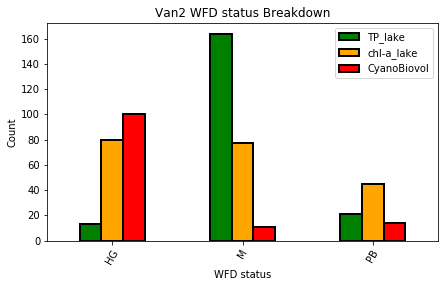

In [116]:
# How unbalanced are the classes? Very!

from collections import OrderedDict

# Color mapping
colors = OrderedDict({1: 'green', 2: 'orange', 3: 'red'})
status_mapping = OrderedDict({1: 'HG', 2: 'M', 3: 'PB'})

# Value counts of target
label_counts = pd.DataFrame()
for var in WFD_class_dict.keys():
    label_counts['%s'%var] = monthly_df['status_%s'%var].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (7, 4), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('WFD status'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in status_mapping.keys()], 
           list(status_mapping.values()), rotation = 60)
plt.title('%s WFD status Breakdown'%basin);

Van1: Very unbalanced. Almost no PB obs for any variables:
- TP split between HG and M (M about 25% higher than HG), tiny bit in PB
- Cyano all HG
- Chl-a mostly HG, little bit in M

Van2: Unbalanced for TP and cyano, chl-a is pretty balanced:
- Almost all TP is M, small HG & PB
- Most cyano is HG, but some M and PB
- chl-a fairly balanced (PB slightly smaller than others)

## Time series plots of monthly data and write output to csv

In [117]:
# Output to csv
monthly_df.to_csv(os.path.join(out_file,'Vansjø_monthly_data_%s.csv' %basin), index_label='Date')

In [118]:
monthly_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pptn,462.0,76.661995,45.278076,0.672300,43.657425,69.495204,103.358857,299.049098
Temp,462.0,5.726480,7.502281,-12.411057,-0.234401,5.286621,12.211478,19.930341
Wind_speed,462.0,3.487214,0.644315,0.200000,3.103253,3.508333,3.895776,5.748387
PET,462.0,47.862841,46.008913,0.000000,3.430929,33.588144,91.305068,143.746935
Q,364.0,5.124776,4.518371,0.082500,1.690943,3.977243,7.125119,34.031467
TP_catch,391.0,81.162981,71.385602,18.000000,38.600000,55.333333,100.628571,646.000000
chl-a_lake,202.0,14.241637,7.982407,1.100000,8.125000,12.550000,18.762500,44.000000
TP_lake,198.0,29.987632,8.208338,11.250000,24.537500,29.404167,33.787500,70.000000
colour_lake,245.0,50.062789,20.885236,10.000000,30.500000,52.000000,65.000000,98.000000
PTI,76.0,2.672643,0.184479,2.319005,2.528540,2.664436,2.803395,3.132615


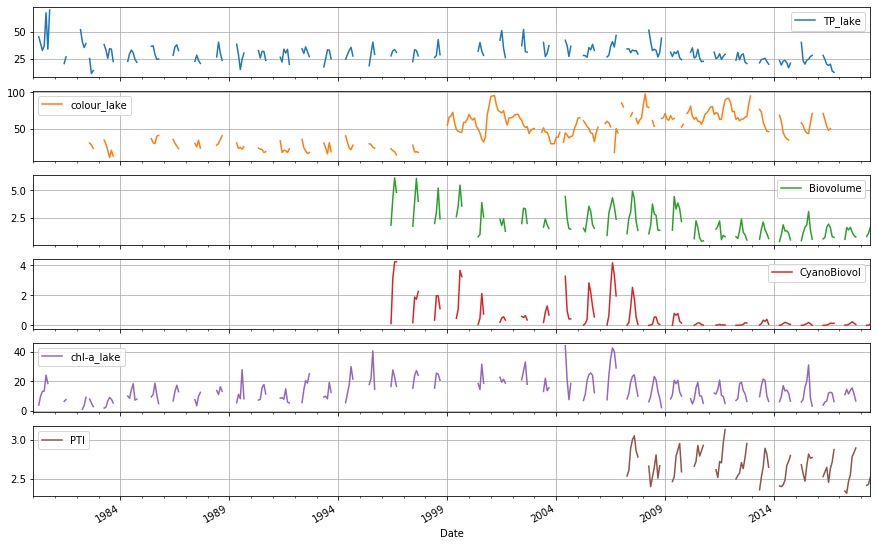

In [38]:
monthly_df[['TP_lake','colour_lake','Biovolume','CyanoBiovol','chl-a_lake','PTI']].plot(subplots=True, grid=True, figsize=(15,10));

In [39]:
monthly_df_slice = monthly_df[['TP_lake','colour_lake','Biovolume','CyanoBiovol','chl-a_lake','PTI']]
monthly_df_slice.head()

,TP_lake,colour_lake,Biovolume,CyanoBiovol,chl-a_lake,PTI
Date,,,,,,
1980-01-31,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-31,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,45.250000,NaN,NaN,NaN,3.971429,NaN
1980-05-31,38.857143,NaN,NaN,NaN,9.948810,NaN


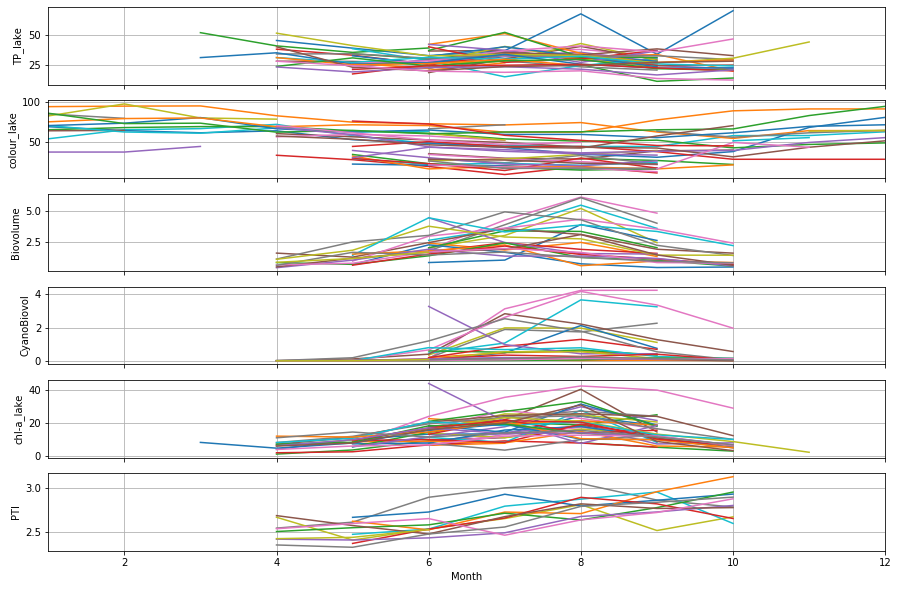

In [88]:
fig, axs = plt.subplots(len(monthly_df_slice.columns), sharex=True, sharey=False, figsize=(15,10))

for group in monthly_df_slice.groupby(monthly_df_slice.index.year):
    year = group[0]
    year_df = group[1]
    year_df = year_df.set_index(year_df.index.month)
    year_df.rename_axis("Month", axis='index', inplace=True)
    
    for i, var in enumerate(year_df.columns):
        year_df[var].plot(ax=axs[i])

for i, var in enumerate(year_df.columns):
    axs[i].set_ylabel(var)
    axs[i].grid(b=True, axis='both')
        
    

In [98]:
daily_df.head()

,Pptn,Temp,Wind_speed,PET,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,PTI,...,Wind_under_Q0.1,Wind_under_Q0.2,Wind_under_Q0.3,Wind_under_Q0.4,Wind_under_Q0.5,Wind_over_Q0.5,Wind_over_Q0.6,Wind_over_Q0.7,Wind_over_Q0.8,Wind_over_Q0.9
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,0.000000,-6.478373,2.9,0.0,4.252,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,False
1980-01-02,0.000000,-10.410182,3.1,0.0,5.544,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,False
1980-01-03,0.000000,-15.997355,1.5,0.0,8.203,NaN,NaN,NaN,NaN,NaN,...,False,True,True,True,True,False,False,False,False,False
1980-01-04,2.693679,-14.694798,1.7,0.0,10.461,NaN,NaN,NaN,NaN,NaN,...,False,True,True,True,True,False,False,False,False,False
1980-01-05,3.016553,-5.953704,1.5,0.0,10.239,NaN,NaN,NaN,NaN,NaN,...,False,True,True,True,True,False,False,False,False,False


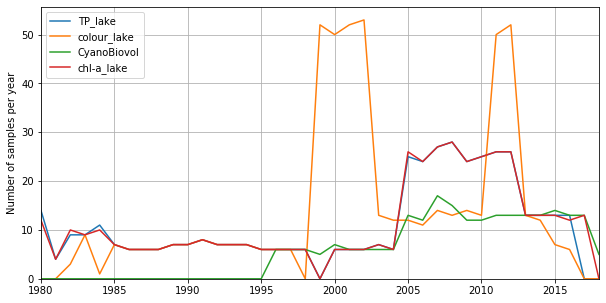

In [103]:
count_df = pd.DataFrame()
target_vars = ['TP_lake','colour_lake','CyanoBiovol','chl-a_lake']
for group in daily_df[target_vars].groupby(daily_df.index.year):
    year = group[0]
    year_df = group[1]
    count_df[year] = year_df.count()

count_df.transpose().plot(figsize=(10,5), grid=True)
plt.ylabel('Number of samples per year')
plt.ylim(ymin=0);

Note that the number of samples per month was low until 2005, so the monthly and seasonal means based on them are much less accurate. Much more intense sampling from 2005 until 2012. Any way of giving these seasons higher weight when fitting the BN I wonder?

As a result of this, the apparently high monthly mean chl-a in 2004, which is a real outlier, looks a bit suspicious as it's only based on 3 data points. Compared to around 8 in 2005, maybe more. **Would be good to also look at number of samples per season per year.**

The imbalance in the number of samples per year for lake colour is particularly massive, due partly to the patching of the two different data sources (MOVAR vs. NIVA). Apparent trends over time could easily be due to changes in sampling frequency.